# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [1]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 12.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [3]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [4]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [5]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [6]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [7]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the latest developments in quantum computing?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, and there have been many exciting developments recently. Here's a breakdown of some of the latest advancements across different areas:

**1. Hardware Advancements:**

*   **Increased Qubit Count and Coherence:**  The race to build larger and more stable quantum computers continues. Companies like IBM, Google, and Rigetti are consistently pushing the boundaries on qubit count.  More importantly, *coherence time* (how long qubits maintain their quantum state) is also improving, allowing for more complex computations. While exact qubit counts can be fluid and the "quality" of qubits varies, the trend is undeniably upward.
*   **Improved Qubit Fidelity:**  Qubit fidelity (the accuracy of quantum operations) is crucial for reliable computation.  Significant progress is being made in reducing error rates through improved control electronics, calibration techniques, and materials science.  Error mitigation techniques are also being actively developed to combat noise.
*   **Diverse Qubit Technologies:**  While superconducting qubits are currently dominant, research into other technologies is thriving.  Trapped ions (IonQ, Quantinuum), neutral atoms (ColdQuanta, Atom Computing), photonic qubits (Xanadu), and silicon spin qubits (PsiQuantum) are all showing promise.  Each technology has its own advantages and disadvantages in terms of scalability, coherence, connectivity, and gate fidelity.  The development of diverse qubit technologies is important for long-term progress.
*   **Cryogenic Control Systems:** Building and controlling a large-scale quantum computer requires sophisticated cryogenic systems to maintain extremely low temperatures. Innovations in cryogenics and control electronics are essential for scaling up these machines. Companies are developing specialized control hardware that can be placed closer to the qubits to reduce signal noise.
*   **Quantum Interconnects:** Research is underway to develop quantum interconnects that can connect multiple quantum processors together, allowing for modular scaling and distributed quantum computing.

**2. Software and Algorithms:**

*   **Quantum Error Correction (QEC):**  This is one of the most critical areas of research.  QEC aims to protect quantum information from errors caused by noise and decoherence.  While fault-tolerant quantum computers are still some way off, significant progress is being made in developing and testing QEC codes. Surface codes are a popular candidate, but other codes like topological codes are also being explored.  Decoding algorithms for QEC are also being improved.
*   **Quantum Algorithm Development:**  Researchers continue to discover and refine quantum algorithms that can outperform classical algorithms for specific tasks.  Beyond the well-known Shor's algorithm (for factoring) and Grover's algorithm (for searching), there's active research in algorithms for quantum simulation, optimization, machine learning, and materials discovery.  Variational Quantum Eigensolver (VQE) and Quantum Approximate Optimization Algorithm (QAOA) are popular hybrid quantum-classical algorithms.
*   **Quantum Compilers and Programming Languages:**  Developing software tools and programming languages that make it easier to program quantum computers is essential for wider adoption.  Companies like IBM (Qiskit), Google (Cirq), and Microsoft (Q#) have developed open-source quantum software development kits (SDKs).  Researchers are also exploring higher-level quantum programming languages and compilers that can automatically translate quantum algorithms into instructions for specific quantum hardware.
*   **Quantum Machine Learning (QML):** This field explores the intersection of quantum computing and machine learning.  Researchers are developing quantum algorithms for tasks such as classification, regression, and clustering, with the potential to speed up machine learning processes or improve their accuracy.  Hybrid quantum-classical machine learning models are also being investigated.
*    **Improved Benchmarking:** Defining appropriate benchmarks to assess the performance and progress of quantum computers is a growing area. This includes exploring metrics beyond just qubit count to better characterize the capability of a quantum computer.

**3. Applications and Use Cases:**

*   **Quantum Simulation:** Quantum computers are particularly well-suited for simulating quantum systems, such as molecules and materials.  This has potential applications in drug discovery, materials science, and fundamental research.  Researchers are using quantum computers to simulate increasingly complex molecules and materials.
*   **Optimization:** Quantum algorithms can be used to solve complex optimization problems that are difficult for classical computers, such as supply chain optimization, financial modeling, and logistics.
*   **Cryptography:** While quantum computers pose a threat to current encryption methods (due to Shor's algorithm), they also offer the potential for quantum-resistant cryptography (also known as post-quantum cryptography or PQC).  Researchers are developing new encryption algorithms that are resistant to attacks from both classical and quantum computers.  The NIST (National Institute of Standards and Technology) has been running a competition to standardize PQC algorithms.
*   **Finance:** Quantum computing has potential applications in finance, such as portfolio optimization, risk management, and fraud detection.
*   **Materials Science:** Quantum simulations are used to predict the properties of new materials before they are synthesized.

**4. Key Players and Ecosystem:**

*   **Tech Giants:** IBM, Google, Microsoft, Amazon, and Intel are heavily invested in quantum computing.
*   **Specialized Quantum Computing Companies:** IonQ, Rigetti, Quantinuum, Xanadu, ColdQuanta, and PsiQuantum are focused on building and developing quantum computers and related technologies.
*   **Academic Institutions:** Universities around the world are conducting cutting-edge research in quantum computing.
*   **Government Funding:** Governments in many countries are investing heavily in quantum computing research and development.
*   **Growing Ecosystem:** A vibrant ecosystem of startups, software vendors, and consulting firms is emerging around quantum computing.

**5. Challenges and Future Directions:**

*   **Scalability:** Building large-scale, fault-tolerant quantum computers remains a significant challenge.
*   **Decoherence:**  Maintaining the coherence of qubits is difficult due to environmental noise.
*   **Error Correction:** Developing effective quantum error correction schemes is crucial for reliable computation.
*   **Algorithm Development:** Discovering new quantum algorithms that can outperform classical algorithms for practical problems is an ongoing effort.
*   **Hardware Development:** Improving the performance and reliability of quantum hardware is essential.
*   **Talent Shortage:** There is a shortage of skilled quantum computing researchers and engineers.
*   **Standardization:** Establishing standards for quantum computing hardware and software is important for interoperability and compatibility.

**In summary, recent developments highlight a field rapidly progressing on many fronts. While a universal, fault-tolerant quantum computer is still some time away, the advancements in hardware, software, and algorithms are paving the way for practical quantum applications in the near future. The continued investment and collaboration from both the public and private sectors are accelerating the pace of innovation.**

To stay up-to-date on the latest developments, I recommend following reputable sources such as:

*   **Scientific Journals:** Nature, Science, Physical Review Letters, Quantum.
*   **Tech News Websites:**  TechCrunch, Wired, The Verge, MIT Technology Review.
*   **Quantum Computing Industry News Sites:** Quantum Computing Report, Inside Quantum Technology.
*   **Company Blogs:**  IBM Quantum, Google AI Blog, Microsoft Quantum Blog.
*   **Conferences:**  American Physical Society (APS) March Meeting, Quantum.Tech, Q2B.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


Recent developments in quantum computing include:

*   **New Quantum Chips and Processors:**
    *   Amazon unveiled its first quantum computing chip, Ocelot, which uses scalable architecture to reduce the costs of implementing quantum error correction.
    *   Google unveiled Willow, its newest quantum chip with significant error-correcting enhancements.
    *   Microsoft's new Majorana 1 processor uses particles that are the opposite of each other and would enable qubits to be rapidly scaled for practical applications.
    *   D-Wave Quantum's new 4,400+ qubit Advantage2TM processor is able to solve issues 25,000 times faster and produce five times better results for high-precision jobs.
*   **Error Correction:** Advancements in error correction techniques are essential for stabilizing qubits and reducing errors during quantum computations. Improved error correction codes and the development of more stable qubits, such as topological qubits, have been made.
*   **Quantum Supremacy:** Quantum computers are tackling increasingly complex problems, outpacing their classical counterparts in specific tasks such as complex simulations and optimization problems.
*   **Quantum Algorithms:** New algorithms designed to take advantage of quantum computing's unique capabilities are being developed, offering the potential to solve problems in fields such as cryptography, materials science, and machine learning more efficiently than ever before.
*   **Quantum Cloud Services:** Quantum computing is gradually becoming more accessible, thanks to the expansion of quantum cloud services offered by tech giants such as IBM, Google, and Amazon.
*   **Quantum-Classical Hybrid Systems:** Development of quantum-classical hybrid systems, which combine the strengths of classical computing with the unique capabilities of quantum processors, allowing for more efficient problem-solving.
*   **Quantum Networks:** Secure communication through metropolitan-scale entangled quantum networks.
*   **Quantum Sensors:** Quantum sensors enhance intracellular sensing and mapping.
*   **Entanglement Multiplexing:** Researchers have achieved the first-ever demonstration of entanglement multiplexing between individual memory qubits in a quantum network using rare-earth ions.
*   **Wireless Quantum Algorithm Transmission:** The first wireless transmission of a quantum algorithm between two distinct quantum processors was accomplished by researchers at the University of Oxford, utilizing quantum entanglement to transmit basic data between computers almost instantly.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context

In [11]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What are the top 3 electric vehicles with the longest range?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "How much do they cost?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "Compare their charging time"
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# # Visualize search usage across the conversation
# print("\n📊 Search Usage Visualization:")
# visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Based on the information available, here are three of the top electric vehicles with the longest range as of April 5, 2025:

1.  **Lucid Air:** This model consistently tops the lists with impressive range figures. The Lucid Air Grand Touring with 19-inch wheels boasts an EPA-estimated range of **512 miles**.
2.  **Chevrolet Silverado EV:** This pickup truck ranks high, offering a range of **460 miles**.
3.  **Mercedes-Benz EQS Sedan:** This luxury sedan is frequently mentioned for its long range, with figures around **452 miles** or **481 miles** claimed depending on the source and specific model.

It's important to note that the actual range you experience can vary significantly based on driving conditions, temperature, driving style, and other factors.



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here's an overview of the estimated costs for the top 3 electric vehicles with the longest range:

1.  **Lucid Air:**
    *   The 2025 Lucid Air has several trims, with varying prices. The Grand Touring trim, which boasts the longest range, starts around **$110,900 - $112,400**. The base price for the Lucid Air Pure starts at approximately **$69,900 - $71,400**. Higher-end models like the Sapphire can reach **$249,000 - $250,500**.
2.  **Chevrolet Silverado EV:**
    *   The 2025 Chevrolet Silverado EV's price varies significantly based on the trim and battery configuration. The base Work Truck (WT) model starts around **$57,095 - $67,633**. The RST trim with the Max range battery can cost around **$97,895**, while the LT Extended Range is listed around **$75,195**.
3.  **Mercedes-Benz EQS Sedan:**
    *   For the 2025 Mercedes-Benz EQS, the starting price is around **$105,550**. Depending on the trim and options, the price can go up to **$130,850.** The EQS 450+ model starts around **$104,400**. Higher performance models like the EQS 580 4MATIC start at approximately **$127,350**.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging time'


To compare the charging times of the Lucid Air, Chevrolet Silverado EV, and Mercedes-Benz EQS Sedan, I will fetch the charging specifications for each vehicle.


Here's a comparison of charging times for the Lucid Air, Chevrolet Silverado EV, and Mercedes-Benz EQS Sedan, based on available information:

**Lucid Air:**

*   **DC Fast Charging:** With a DC fast charging station, the Lucid Air Pure and Touring models have a maximum charging capacity of 200 kW, meaning it would take approximately **25 minutes** to charge the Lucid Air Pure and 26 minutes to charge the Lucid Air Touring from 10 to 80 percent. The Lucid Air Grand Touring and Dream Editions have a maximum charging capacity of 300 kW, meaning it would take around **22 minutes** to charge the Lucid Air Grand Touring and 23 minutes to charge the Lucid Air Dream from 10 to 80 percent. Lucid claims its 900V+ architecture can add up to 400 km (around 250 miles) in about 15 minutes.
*   **Level 2 Charging (AC):** Using a standard AC charging station, all models of the Lucid Air have a maximum charging capacity of 22 kilowatts (kW), meaning it would take around 4 hours and 26 minutes to charge the Lucid Air Pure, 4 hours and 38 minutes to charge the Lucid Air Touring, 5 hours and 39 minutes to charge the Lucid Air Grand Touring, and 5 hours and 57 minutes to charge the Lucid Air Dream Editions P and R from 0 to 100 percent. Using a typical 7kW home charging point, it takes approximately 11 hours and 54 minutes to charge from zero to full.

**Chevrolet Silverado EV:**

*   **DC Fast Charging:** The Silverado EV supports DC fast charging up to 350 kW, allowing drivers to replenish 100 miles of range in just 10 minutes at public charging stations. Charging from 10-80% takes approximately 40.5 minutes.
*   **Level 2 Charging:** With a professionally installed Level 2 home charging system, a full charge takes approximately 8-10 hours.
*   **Level 1 Charging:** Using a standard outlet at home (Level 1 Charging) might extend the charging time to 24 to 48 hours.

**Mercedes-Benz EQS Sedan:**

*   **DC Fast Charging:** Can get an 80% charge in about 31 minutes using a DC fast charger at 200kW. Some sources claim 15-20 minutes to charge to 80%.
*   **Level 2 Charging:** Using a Level 2 home charger, it takes approximately 10-12 hours to charge from 0 to 100%. With a 240V connection at 9.6kW, charging from 10-100% takes about 11.5 hours.

**Summary Table:**

| Charging Method        | Lucid Air                         | Chevrolet Silverado EV                | Mercedes-Benz EQS Sedan             |
| :--------------------- | :-------------------------------- | :------------------------------------- | :---------------------------------- |
| DC Fast Charging (10-80%) | ~22-26 mins (depending on model) | ~41 mins                             | ~31 mins                           |
| Level 2 Home Charging    | ~4.5-6 hrs (0-100%)               | ~8-10 hrs (0-100%)                    | ~10-12 hrs (0-100%)                 |

**Important Considerations:**

*   Charging times can vary based on factors such as the charger's output, the battery's initial state of charge, battery temperature, and ambient temperature.
*   The charging rate often slows down as the battery reaches full capacity to protect the battery's longevity.
*   The information above represents estimates from the manufacturer and various sources. Real-world charging times may differ.



📊 Search Results Used:



# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [12]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)

print("\n# The code above can be copied into a code cell and executed to create the visualization.")
print("# Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I will find the GDP growth rates for the world's top 5 economies for the most recent year, create a Pandas DataFrame, and then generate a Matplotlib bar chart visualizing the data with proper labels, title, and color coding.



Based on the search results, here's the information on the top 5 economies and their GDP growth rates:

1.  **United States:** GDP \$30.34 trillion, Growth 2.2% (2025 Projected)
2.  **China:** GDP \$19.53 trillion, Growth 4.5% (2025 Projected)
3.  **Germany:** GDP \$4.92 trillion, Growth 0.8% (2025 Projected)
4.  **Japan:** GDP \$4.39 trillion, Growth 1.1% (2025 Projected)
5.  **India:** GDP \$4.27 trillion, Growth 6.5% (2025 Projected)

Here's the Python code to create the DataFrame and generate the bar chart:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for the top 5 economies and their GDP growth rates
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.2, 4.5, 0.8, 1.1, 6.5]}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate for better visualization
df = df.sort_values(by='GDP Growth Rate', ascending=False)

# Define colors for the bars
colors = ['green', 'skyblue', 'lightcoral', 'gold', 'lightgreen']  # Example colors

# Create the bar chart using matplotlib
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2025 Projected)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add gridlines for easier comparison
plt.grid(axis='y', linestyle='--')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Show the chart
plt.show()
```



This code will:

1.  **Import necessary libraries:** `pandas` for DataFrame creation and `matplotlib.pyplot` for plotting.
2.  **Create a DataFrame:**  A Pandas DataFrame is created from the provided data.
3.  **Sort the DataFrame:** Sorts by GDP growth rate for better visualization.
4.  **Define Colors:** Defines a list of colors to use for the bars.
5.  **Create a bar chart:** Uses `plt.bar()` to generate the bar chart.
6.  **Add labels and title:** Sets the x and y-axis labels, chart title, and rotates the x-axis labels for readability.
7.  **Add gridlines:** Adds horizontal gridlines to make it easier to compare the bar heights.
8.  **Add value labels:**  Adds the GDP growth rate value on top of each bar.
9.  **Adjust layout:** Uses `plt.tight_layout()` to ensure all labels fit within the figure.
10. **Show the chart:** Displays the generated bar chart.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


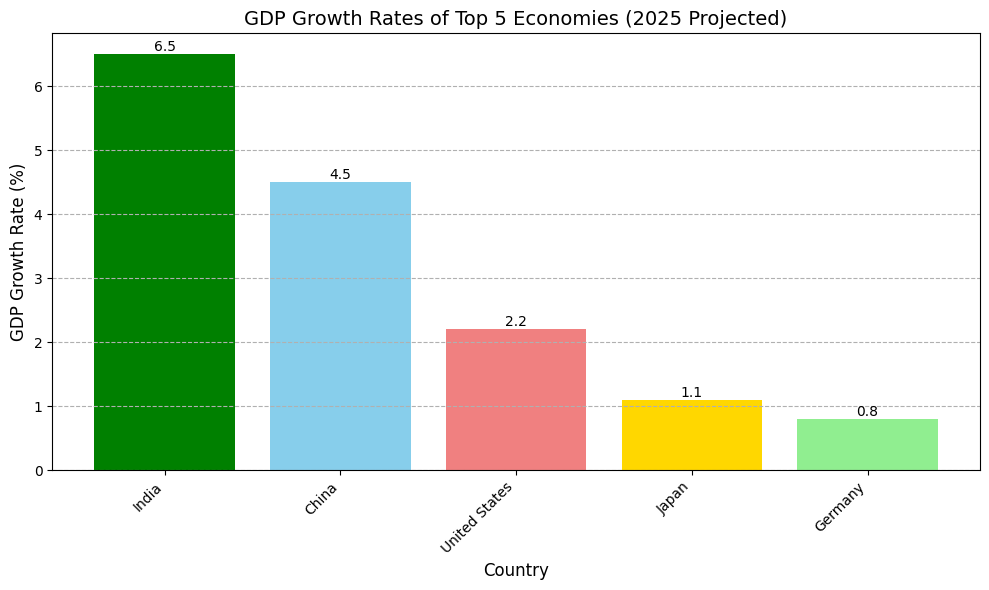

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for the top 5 economies and their GDP growth rates
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.2, 4.5, 0.8, 1.1, 6.5]}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate for better visualization
df = df.sort_values(by='GDP Growth Rate', ascending=False)

# Define colors for the bars
colors = ['green', 'skyblue', 'lightcoral', 'gold', 'lightgreen']  # Example colors

# Create the bar chart using matplotlib
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2025 Projected)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add gridlines for easier comparison
plt.grid(axis='y', linestyle='--')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Show the chart
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving nền cmt8.jpg to nền cmt8.jpg
Uploaded image:


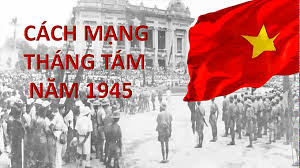


🔍 Analyzing image...


Okay, here's the information about the image:

**Main Subject:** August Revolution of 1945 in Vietnam

**Description:** The image shows a stylized depiction of the August Revolution in Vietnam in 1945. It features the flag of Vietnam prominently, with the words "Cách Mạng Tháng Tám Năm 1945" (August Revolution 1945) superimposed. There are also people in the background.



📊 Search Results Used:



🔍 Searching for detailed information...


The August Revolution, also known as the August General Uprising (Cách-mạng tháng Tám), was a revolution by the Việt Minh against the Empire of Vietnam from August 16 to September 2, 1945.

Here's a breakdown:

*   **Context:** Vietnam was under French colonial rule but occupied by Japan during World War II. In March 1945, Japan took direct control, ending the nominal French authority. This created an opportunity for Vietnamese nationalists.
*   **The Việt Minh:** Hồ Chí Minh formed the Viet Nam Doc Lap Dong Minh (League for the Independence of Vietnam), or Việt Minh, in 1941. It was a communist-led movement aimed at Vietnamese independence.
*   **The Revolution:** Following Japan's surrender in August 1945, the Viet Minh seized the opportunity to take control. They took over Hanoi on August 19, and within a couple of weeks, had control over most of North and Central Vietnam. Emperor Bảo Đại abdicated on August 25.
*   **Declaration of Independence:** On September 2, 1945, Ho Chi Minh declared the establishment of the Democratic Republic of Vietnam (DRV).
*   **Aftermath:** France initially recognized Vietnamese sovereignty but later tried to reassert colonial rule, leading to conflict.

**Interesting Facts:**

*   The August Revolution is considered the first significant victory of the Vietnamese people under the Communist Party's leadership.
*   The Việt Minh successfully attracted many non-communist nationalists.
*   Ho Chi Minh's declaration of independence was inspired by the American Declaration of Independence.
*   The revolution led to the end of the Vietnamese monarchy.
*   The August Revolution is seen as a major turning point in Vietnamese history, marking the end of French colonialism.
*   The success of the August Revolution proved the soundness of the revolutionary path, the wise leadership, strategic vision, and timely action of the Communist Party and President Ho Chi Minh.



📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): What are common misconceptions about it?

🔍 Searching for answer to: 'What are common misconceptions about it?'


While comprehensive information on misconceptions surrounding the August Revolution is scarce, here's a breakdown of potential misunderstandings, based on available information and general historical analysis:

*   **The Viet Minh success was solely due to the Japanese surrender:** Some argue that the Viet Minh simply "happened to be there" when Japan surrendered. However, this discounts the Viet Minh's years of preparation, organization, and mobilization of the Vietnamese population.
*   **The Revolution was a purely communist movement:** While led by communists, the Việt Minh attracted a broad range of nationalists and patriots who desired independence, not necessarily communism.
*   **The August Revolution immediately solved all of Vietnam's problems:** The declaration of independence was just the beginning. The French soon attempted to reassert control, leading to decades of war.
*   **There was a collapse of social order:** It is a misconception that social and public order in Viet-Nam suddenly collapsed after Japan's surrender. In fact, the process of social discomposition (or destabilization) had started as early as when Japanese troops had landed on Indochinese soil.



📊 Search Results Used:


In [15]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from google.genai.types import HttpOptions, Part
from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return image_file.read()

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    image_bytes = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""

    What is shown in this image? Please identify the main subject and provide a brief description in format below: \n
    Main Subject: subject \n
    Description: description \n
    """

    print("\n🔍 Analyzing image...")

    multimodal_chat.send_message([Part.from_bytes(data=image_bytes, mime_type="image/jpeg")])
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [16]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


Based on the latest available data and projections, here's an analysis of the electric vehicle (EV) market in Europe:

**1. Current State & Market Share:**

*   **Overall Health:** The European EV market, while still growing, experienced a slowdown or stagnation phase in 2024 after rapid growth in previous years. Some sources report a slight year-over-year decrease in overall EV sales for 2024. Battery Electric Vehicles (BEVs) remain the dominant EV type.
*   **Market Share (Powertrain):** In 2024, BEVs were the third most popular powertrain choice for European buyers, holding about 13.6% market share, surpassing diesel (11.9%). Petrol cars led (33.3%), followed by Hybrid Electric Vehicles (HEVs) at 30.9%. Plug-in Hybrid Electric Vehicles (PHEVs) accounted for around 7.1%. Early 2025 data suggests BEV share was around 16% in January/February 2025.
*   **Sales Volume:** In 2023, nearly 3.2 million electric cars (BEVs and PHEVs) were registered in Europe (2.4 million in the EU), a 20% increase from 2022. Preliminary data for 2024 suggests around 1.99 million BEVs were sold across Europe (including UK, EFTA), a slight decrease (-1.3%) from 2023. For the EU alone, around 1.45 million BEVs were registered in 2024, a 5.9% decline compared to 2023.
*   **Regional Differences:** EV adoption varies significantly across Europe. Norway leads with the highest share (around 91-97% in recent reports), followed by countries like Sweden, Iceland, Denmark, and the Netherlands (all above 50%). Germany, France, and the UK are major volume markets, though Germany saw a drop in market share (from 30% to 25% in 2023) and sales (-27.4% in 2024) primarily due to subsidy cuts. The UK overtook Germany as the largest BEV market in Europe in 2024 by volume.

**2. Major Players & Market Share (Brands/Groups):**

*   **Top Selling Models (based on 2024 data):**
    *   Tesla Model Y consistently leads as the best-selling EV in Europe.
    *   Tesla Model 3 is typically the second best-selling model.
    *   Other strong performers include the Skoda Enyaq, Volvo EX30, Volkswagen ID.4, and MG 4.
*   **Top Selling Brands (based on 2024 data):**
    *   Tesla remained the best-selling EV *brand* in Europe in 2024 for the third consecutive year, though its market share slightly decreased.
    *   BMW secured the second position, showing strong growth.
    *   Mercedes-Benz took third place.
    *   Other brands with significant EV sales include Volkswagen, Skoda, Audi, Volvo, Kia, Hyundai, and MG.
*   **Top Selling Manufacturer Groups (based on 2024 data):**
    *   Volkswagen Group was the leading OEM (Original Equipment Manufacturer) group in terms of overall EV sales volume.
    *   BMW Group ranked second.
    *   Tesla was third as a group (since it's a single brand).
    *   Stellantis followed closely.

**3. Growth Trends & Influencing Factors:**

*   **Recent Slowdown (2024):** The market experienced a slowdown, sometimes described as stagnation, in 2024. Factors contributing include:
    *   Phasing out or reduction of government subsidies in key markets like Germany.
    *   Carmakers potentially prioritizing higher-margin ICE vehicles or expensive EV models while awaiting stricter CO2 targets.
    *   Higher average prices for EVs compared to previous years.
*   **Projected Rebound (2025 onwards):** Analysts widely expect significant growth to resume in 2025 and beyond. Key drivers include:
    *   **Stricter EU Regulations:** Tighter CO2 emission standards kick in from 2025, mandating a higher share of zero-emission vehicles (potentially pushing EV share towards 22-24% in 2025). The 2035 target for 100% zero-emission new cars and vans remains a strong long-term driver.
    *   **Increased Model Availability:** A wider range of EV models, including more affordable options (sub-€25,000) from manufacturers like Renault, Stellantis, and Hyundai/Kia, are expected to launch, broadening consumer appeal.
    *   **Infrastructure Development:** Regulations like AFIR (Alternative Fuels Infrastructure Regulation) mandate the expansion of charging infrastructure, such as fast chargers every 60km along major transport networks (TEN-T).
    *   **Battery Demand:** Strong EV sales growth fuels massive demand for lithium-ion batteries, projected to increase significantly by 2030.
*   **Market Dynamics:** Increased competition, particularly from Chinese automakers introducing affordable models, is shaping the market. Potential EU tariffs on Chinese imports could influence dynamics.

In summary, the European EV market is currently navigating a transition phase after years of rapid expansion, influenced by subsidy changes and manufacturer strategies. However, driven by stringent regulations, expanding model choices (especially affordable ones), and infrastructure development, strong growth is anticipated to resume from 2025 onwards, solidifying Europe's position as a leading global EV market behind China.


📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow


In [18]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively
# rất tiện khi làm nghiên cứu, sử dụng model pro

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the research stages
    # print("\n📊 Research Stage Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


Okay, let's break down the field of Quantum Machine Learning (QML) for Drug Discovery.



## Quantum Machine Learning (QML) for Drug Discovery: Overview

Quantum Machine Learning (QML) is an emerging interdisciplinary field that combines the principles of quantum computing with machine learning techniques. Its application to drug discovery holds the potential to revolutionize how new therapies are found and developed by tackling complex problems that are currently intractable for classical computers.

**1. Main Concepts and Terminology**

*   **Quantum Computing (QC):** A type of computing that utilizes quantum-mechanical phenomena, such as superposition and entanglement, to perform calculations. Unlike classical bits (0 or 1), quantum bits (qubits) can exist in multiple states simultaneously (superposition) and can be linked (entangled) such that their fates are intertwined, regardless of distance. This allows quantum computers to explore vast computational spaces concurrently.
*   **Machine Learning (ML):** A subset of artificial intelligence where algorithms learn patterns from data to make predictions or decisions without being explicitly programmed. In drug discovery, ML is used for tasks like predicting molecular properties, identifying drug candidates, and analyzing biological data.
*   **Quantum Machine Learning (QML):** The intersection of QC and ML. QML aims to leverage quantum phenomena to enhance or accelerate ML tasks. This could involve running parts of an ML algorithm on a quantum computer, using quantum computers to generate or process complex data for ML models, or developing entirely new quantum algorithms for learning.
*   **Drug Discovery Pipeline:** The complex, lengthy, and expensive process of bringing a new drug to market. Key stages include target identification (finding biological molecules involved in disease), lead generation (finding molecules that interact with the target), lead optimization (refining these molecules), preclinical testing (animal studies), and clinical trials (human studies).
*   **Key QML Applications in Drug Discovery:**
    *   **Molecular Simulation:** Accurately simulating molecular behavior, structure, and interactions (e.g., drug binding to a protein target) is crucial but computationally very demanding classically. QC promises more accurate and efficient simulations.
    *   **Virtual Screening:** Rapidly screening vast libraries of potential drug compounds computationally to identify promising candidates. QML could potentially accelerate this search or improve its accuracy.
    *   **Property Prediction:** Using ML models (potentially enhanced by quantum methods) to predict properties like a molecule's efficacy, toxicity (ADMET), or how it will be absorbed and metabolized by the body (pharmacokinetics).
    *   **Generative Models:** Creating novel molecular structures with desired properties using QML-based generative algorithms (like Quantum Generative Adversarial Networks - QGANs).
*   **Hybrid Quantum-Classical Approaches:** Given the limitations of current quantum hardware, many QML approaches involve using both quantum and classical computers, leveraging the strengths of each. Often, computationally intensive parts are run on a quantum processor, while data preparation and post-processing occur classically.

**2. Current State of Development**

*   **Nascent Stage:** QML for drug discovery is still in its early stages of research and development. While there's significant theoretical promise and investment, practical, widespread application is not yet a reality.
*   **NISQ Era:** We are currently in the Noisy Intermediate-Scale Quantum (NISQ) era. This means current quantum computers have a limited number of qubits (intermediate-scale) and are susceptible to errors (noise) due to environmental factors and imperfect control. This significantly limits the complexity and duration of calculations they can perform reliably.
*   **Focus on Proof-of-Concept:** Much current research involves demonstrating the potential of QML on specific, often simplified, drug discovery problems using simulations or small-scale experiments on existing NISQ hardware.
*   **Algorithm Development:** Researchers are actively developing and refining QML algorithms (e.g., Quantum Support Vector Machines (QSVMs), Quantum Neural Networks (QNNs), Variational Quantum Eigensolvers (VQEs)) tailored for drug discovery tasks.
*   **Software and Platforms:** Development platforms and software libraries (like TensorFlow Quantum, PennyLane, Qiskit, Amazon Braket, NVIDIA CUDA-Q) are becoming available, making it easier for researchers to experiment with QML.
*   **Hybrid Models Dominate:** Due to NISQ limitations, hybrid quantum-classical algorithms are the most common approach being explored currently.

**3. Key Players or Contributors**

The field involves a diverse ecosystem:

*   **Quantum Hardware/Software Providers:** Companies building quantum computers and the software to run them. Examples: IBM, Google Quantum AI, D-Wave Systems, Rigetti Computing, IonQ, Xanadu, Pasqal. Cloud providers like AWS, Microsoft Azure, and Google Cloud also offer access to various quantum hardware and simulators.
*   **Pharmaceutical Companies:** Major pharma companies are actively exploring QML, often through partnerships, pilot programs, or internal research teams. Examples include Roche, Merck, GSK, Biogen, Pfizer, Moderna, Amgen. Many large firms (around 65%) have initiated pilot programs.
*   **Specialized Startups & Technology Companies:** Companies focusing specifically on applying quantum computing (including QML) to drug discovery and materials science. Examples: Qubit Pharmaceuticals, POLARISqb, Zapata AI, Menten AI, Kuano, Qunova Computing, QSimulate, Sandbox AQ, Quantinuum (formerly Cambridge Quantum/CQC). Accenture works with Biogen. NVIDIA provides platforms like CUDA-Q supporting QML simulations.
*   **Academic Institutions & Research Centers:** Universities and research labs worldwide are crucial hubs for fundamental research and algorithm development (e.g., University of Toronto, St. Jude Children's Research Hospital, Yale). Research consortia like QuPharm also exist.

**4. Recent Major Developments (as of early 2025)**

*   **Improved Hybrid Algorithms:** Continued refinement of hybrid quantum-classical approaches designed to extract value even from NISQ devices. This includes better error mitigation techniques.
*   **Quantum-Enhanced ML Models:** Demonstrations showing QML models potentially outperforming classical counterparts on specific tasks, such as predicting molecular properties or binding affinity, often in simulated environments or on small datasets. For example, recent work showed quantum computing boosting ML for identifying KRAS protein ligands. Kipu Quantum reported significant accuracy improvements in toxicity prediction using quantum feature mapping.
*   **Generative QML:** Increased focus on using QML (like QGANs) for *de novo* molecule generation, aiming to design entirely new drug candidates.
*   **Platform Integration:** Better integration of quantum computing resources into classical high-performance computing (HPC) and cloud workflows, making QML more accessible. Platforms like NVIDIA's CUDA-Q facilitate simulation of QML workloads on GPUs.
*   **Increased Investment & Partnerships:** Continued significant investment from both venture capital and established pharmaceutical companies into QML research and startups. Strategic collaborations between pharma and quantum tech companies are becoming more common. The global quantum computing market for drug discovery is projected to grow significantly, reaching billions by 2030.
*   **Focus on Specific Pipeline Stages:** Research is moving beyond general concepts to targeting specific bottlenecks in the drug discovery pipeline, like lead optimization or ADMET prediction.

## Interesting Subtopics for Further Exploration

Based on the current state and challenges, here are 3-5 specific subtopics ripe for deeper exploration:

1.  **Quantum Algorithms for Molecular Property Prediction:** Delve into specific QML algorithms (like QNNs, QSVMs, VQEs) being adapted or developed to predict crucial molecular properties such as binding affinity, solubility, toxicity (ADMET), and pharmacokinetic profiles. How do they compare to state-of-the-art classical ML methods (like Graph Neural Networks) in terms of accuracy, data requirements, and computational cost on NISQ devices?
2.  **Generative Quantum Models for *De Novo* Drug Design:** Explore the use of Quantum Generative Adversarial Networks (QGANs), Quantum Variational Autoencoders (QVAEs), or other quantum generative approaches to design novel molecules with specific desired characteristics (e.g., high affinity for a target, good ADMET properties). What are the challenges in representing molecular structures on quantum computers and ensuring the generated molecules are chemically valid and synthesizable?
3.  **Hybrid Quantum-Classical Workflows in Practice:** Investigate the practical implementation of hybrid workflows. How are tasks divided between classical and quantum processors? What are the bottlenecks in data transfer and communication? How are error mitigation techniques integrated, and how effective are they for realistic drug discovery problems? Case studies like the HypaCADD project or collaborations (e.g., St. Jude/U Toronto, Accenture/Biogen, Pasqal/Qubit Pharmaceuticals) could provide insights.
4.  **Data Encoding Strategies for QML in Chemistry/Biology:** A fundamental challenge is how to effectively represent complex chemical and biological data (e.g., molecular graphs, protein structures, genomic data) as quantum states (qubits). Research different encoding techniques (e.g., amplitude encoding, basis encoding, Hamiltonian encoding) and their suitability for various QML algorithms and drug discovery tasks. How does the choice of encoding impact algorithm performance and resource requirements?
5.  **Benchmarking QML against Classical and Quantum-Inspired Methods:** Critically evaluate the performance of current QML algorithms for drug discovery tasks against both leading classical ML methods and *quantum-inspired* classical algorithms (algorithms running on classical hardware but inspired by quantum principles). When and where does genuine quantum advantage seem most plausible in the near-term (NISQ era) versus the long-term (fault-tolerant era)?

These subtopics touch upon the core challenges and opportunities at the intersection of quantum computing, machine learning, and pharmaceutical research today.


📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are 3 subtopics extracted from the previous list that represent particularly valuable areas for further exploration in Quantum Machine Learning (QML) for Drug Discovery:

**1. Subtopic Name: Hybrid Quantum-Classical Workflows in Practice**

*   **Significance:** Current quantum computers (NISQ era) are too small and noisy to handle entire complex drug discovery problems independently. Hybrid workflows, which strategically combine quantum and classical computing resources, are the only viable path to potentially extract value from QML in the near to mid-term. Understanding how to design, implement, and optimize these workflows is crucial for making any practical progress.
*   **Areas for Deeper Research:**
    *   **Optimal Task Decomposition:** How to best identify which parts of a drug discovery problem (e.g., specific molecular simulations, feature extraction for ML, optimization steps) are most suitable for quantum processing versus classical processing?
    *   **Integration Challenges:** What are the practical bottlenecks and overheads in data transfer, communication latency, and synchronization between quantum processing units (QPUs) and classical CPUs/GPUs? How can these be mitigated?
    *   **Error Mitigation Integration:** How can quantum error mitigation techniques be effectively incorporated into hybrid workflows without negating potential quantum speedups? How does their effectiveness vary across different drug discovery tasks and quantum hardware platforms?
    *   **Workflow Management:** What software architectures and workflow management systems are needed to efficiently orchestrate and manage complex hybrid computations involving diverse hardware and algorithms?
    *   **Real-world Case Studies:** Detailed analysis of existing hybrid implementations (like those targeting KRAS inhibitors or specific molecular simulations) to understand their performance, limitations, and practical lessons learned.

**2. Subtopic Name: Generative Quantum Models for *De Novo* Drug Design**

*   **Significance:** This area aims to move beyond screening existing molecules to designing entirely new drug candidates with desired properties. Quantum generative models (like QGANs or QVAEs) theoretically offer advantages in exploring vast chemical spaces and potentially generating more diverse or novel molecular structures compared to classical generative models, due to their ability to leverage quantum phenomena like superposition and entanglement. Success here could dramatically accelerate the identification of innovative lead compounds.
*   **Areas for Deeper Research:**
    *   **Molecular Representation:** How can complex molecular structures (often represented as graphs or strings classically) be effectively encoded into quantum states (qubits) for generative models? How does the choice of representation impact model capacity and training?
    *   **Model Expressivity & Capacity:** Can quantum generative models truly represent complex probability distributions of valid, drug-like molecules more effectively or efficiently than state-of-the-art classical models (e.g., graph neural networks, transformers)? How does model capacity scale with qubit count and circuit depth?
    *   **Training Stability & Efficiency:** Classical GANs are notoriously difficult to train. Do Quantum GANs (QGANs) face similar or unique training challenges (e.g., barren plateaus, mode collapse)? Can hybrid quantum-classical training schemes improve stability?
    *   **Constraint Satisfaction:** How can crucial chemical constraints (valency rules, synthetic accessibility, desired pharmacological properties like binding affinity or ADMET profiles) be incorporated into the quantum generative process?
    *   **Comparison with Classical Models:** Rigorous benchmarking of quantum generative models against leading classical approaches (like MolGAN, LatentGAN, etc.) on standardized datasets and *de novo* design tasks.

**3. Subtopic Name: Benchmarking QML against Classical and Quantum-Inspired Methods**

*   **Significance:** It is essential to rigorously determine if and when QML actually provides a tangible advantage ("quantum advantage") over highly optimized classical machine learning algorithms or even quantum-inspired classical algorithms for specific drug discovery tasks. Without clear, relevant benchmarks, it's impossible to gauge progress, justify investment, or guide research effectively. This subtopic addresses the critical need for fair comparison and validation.
*   **Areas for Deeper Research:**
    *   **Relevant Benchmark Tasks & Datasets:** Defining meaningful benchmark problems directly relevant to bottlenecks in the drug discovery pipeline (e.g., binding affinity prediction, ADMET property prediction, hit-to-lead optimization), using high-quality, realistic datasets beyond simplified examples like QM9 or MoleculeNet components often used out of context.
    *   **Fair Comparison Metrics:** Establishing appropriate metrics for comparing quantum, classical, and quantum-inspired algorithms, considering not just prediction accuracy but also computational cost (time, resources), data requirements, scalability, and robustness to noise (especially for NISQ algorithms).
    *   **Identifying True Quantum Advantage:** Designing experiments and theoretical analyses to isolate genuine quantum effects (like entanglement) contributing to performance, distinguishing them from advantages gained simply through different model structures or optimization techniques achievable classically.
    *   **Quantum-Inspired Algorithms:** Investigating the performance of classical algorithms inspired by quantum principles (e.g., tensor networks, specific optimization techniques) to understand how much "quantum advantage" can be replicated on classical hardware.
    *   **NISQ vs. Fault-Tolerant Regimes:** Characterizing the performance scaling and potential advantages of QML algorithms on current NISQ hardware (with noise and limited qubits) versus projected performance on future fault-tolerant quantum computers.


📊 Search Results Used:



📊 Stage 3: Deep dive into first subtopic


Okay, let's perform a comprehensive deep dive into the subtopic: **Hybrid Quantum-Classical Workflows in Practice for Drug Discovery**.

This area focuses on the practical necessity of combining quantum processing units (QPUs) with classical computers (CPUs/GPUs) to tackle drug discovery problems, given the limitations of current Noisy Intermediate-Scale Quantum (NISQ) hardware.

**1. Latest Research Findings or Developments**

*   **Dominance of Variational Algorithms:** The most common hybrid approaches currently employ variational quantum algorithms like the Variational Quantum Eigensolver (VQE) and Quantum Approximate Optimization Algorithm (QAOA). In drug discovery, VQE is heavily researched for calculating molecular ground state energies, which is crucial for determining properties like binding affinity between a drug candidate and its protein target. Classical optimizers are used to tune the parameters of the quantum circuit run on the QPU.
*   **Focus on Specific Sub-Problems:** Research isn't aiming to run the entire drug discovery pipeline on quantum computers. Instead, efforts concentrate on accelerating specific, computationally intensive steps. Examples include:
    *   **Binding Energy Calculations:** Simulating the interaction energy between a small molecule (ligand) and the active site of a protein target. Research often involves simplified models or active site fragments due to qubit limitations. Recent studies demonstrate VQE calculations for small molecules or simplified protein active sites, validating quantum approaches against classical methods like Density Functional Theory (DFT) but often on problems still tractable classically. (e.g., simulating systems requiring 10-30 qubits).
    *   **Quantum Kernels for ML:** Using QPUs to compute kernel functions within classical machine learning models (like Support Vector Machines - SVMs) for tasks like predicting molecular properties (e.g., toxicity, solubility). The idea is that quantum feature spaces might capture complex correlations better. Research here shows potential advantages in specific datasets but generalization remains an open question.
*   **Integration with Classical HPC:** Platforms and software are emerging to integrate quantum computation seamlessly into existing high-performance computing (HPC) workflows. NVIDIA's CUDA-Q platform, for example, allows simulating quantum circuits on GPUs and aims to provide a unified programming environment for hybrid CPU/GPU/QPU systems. AWS Braket Hybrid Jobs and Azure Quantum also provide tools to manage the classical and quantum components of a workflow.
*   **Application Demonstrations:** Several collaborations report proof-of-concept demonstrations. For instance, studies (often involving partnerships like Biogen/Accenture or St. Jude/U Toronto) explore using hybrid methods to screen fragments or predict properties for targets like the KRAS protein, a challenging cancer target. These studies often highlight the current necessity of significant error mitigation.

**2. Key Challenges or Controversies**

*   **NISQ Limitations (Noise, Scale, Coherence):** This remains the biggest hurdle. Current QPUs have limited qubits (< few hundred logical qubits, often far fewer usable due to noise), short coherence times (limiting circuit depth), and high error rates (10^-2 to 10^-3 per gate). This severely restricts the size and complexity of molecules or interactions that can be simulated accurately. Hybrid algorithms are often limited by the noise accumulating in the quantum part.
*   **Data Encoding/Loading Bottleneck:** Efficiently encoding classical molecular data (e.g., atomic positions, basis sets) onto qubits and loading it into the QPU is a significant challenge. This "input problem" can sometimes negate potential quantum speedups, as the classical preprocessing or data loading time dominates.
*   **Measurement Overhead:** Variational algorithms require many repeated measurements of the quantum state to estimate expectation values, which is time-consuming and can be a bottleneck, especially when combined with the classical optimization loop.
*   **Error Mitigation Overhead:** While techniques like Zero-Noise Extrapolation (ZNE), Probabilistic Error Cancellation (PEC), and dynamical decoupling are crucial for getting meaningful results from NISQ hardware, they add significant computational overhead (requiring more circuit executions or more complex circuits), further slowing down the hybrid workflow.
*   **Algorithm Performance & Barren Plateaus:** Variational algorithms can suffer from "barren plateaus," where the optimization landscape becomes flat, making it extremely difficult for the classical optimizer to find the optimal parameters, especially as the number of qubits increases.
*   **Demonstrating "Quantum Advantage":** A major ongoing challenge and point of discussion is proving that these hybrid workflows actually provide a *practical* advantage (in terms of speed, cost, or solution quality) over state-of-the-art *classical* algorithms running on powerful classical hardware for *relevant* drug discovery problems. Many current demonstrations solve problems that are still efficiently solvable classically, serving more as validation exercises.

**3. Notable Innovations or Breakthroughs**

*   **Workflow Orchestration Platforms:** The development of software platforms designed specifically to manage hybrid workflows is a key innovation. Examples:
    *   **AWS Braket Hybrid Jobs:** Simplifies running algorithms that iterate between classical and quantum resources by managing infrastructure provisioning and job execution.
    *   **Zapata AI's Orquestra:** A platform designed for building and executing quantum and quantum-inspired workflows across different hardware backends, aiming to manage the complexity of hybrid computation.
    *   **NVIDIA CUDA-Q:** Aims to provide a unified programming model for hybrid CPU/GPU/QPU applications, enabling tighter integration and leveraging GPU power for simulation and classical components.
*   **Advanced Error Mitigation Schemes:** Research continues to yield more sophisticated error mitigation techniques that are less resource-intensive or more effective, pushing the boundaries of what can be achieved on NISQ devices. Techniques are being integrated directly into software libraries (e.g., in IBM's Qiskit).
*   **Hardware-Aware Algorithms & Compilation:** Development of algorithms and compilation techniques that are specifically tailored to the connectivity, gate sets, and noise characteristics of a particular QPU. This minimizes errors and makes better use of available resources.
*   **Resource Optimization:** Techniques to reduce the number of qubits or circuit depth required for specific calculations (e.g., using entanglement forging or specific basis set choices in VQE), making slightly larger problems accessible to current hardware.
*   **GPU Acceleration of Simulations:** Using powerful GPUs (like NVIDIA's A100 or H100) with platforms like CUDA-Q or PennyLane to simulate larger quantum circuits classically than previously feasible. This accelerates research and algorithm testing even without direct QPU access and helps benchmark QPU performance.

**4. Future Directions and Potential Impacts**

*   **Tighter Hardware Integration:** Expect closer physical and logical integration of QPUs with classical HPC resources (CPUs/GPUs) to reduce communication latency, potentially through co-packaged solutions or improved interconnects.
*   **Improved Error Handling:** Near-term focus will remain on better error *mitigation*. Longer-term, the advent of early fault-tolerant quantum computers will significantly change the landscape, allowing deeper circuits and reducing reliance on complex mitigation, although hybrid approaches might still be relevant.
*   **AI-Driven Workflow Optimization:** Using AI/ML techniques to automatically optimize hybrid workflows – deciding task decomposition, selecting optimal algorithms, tuning parameters, and potentially even co-designing algorithms and hardware configurations.
*   **Standardization and Abstraction:** Development of higher-level programming models and standardized interfaces (APIs) that abstract away some of the low-level complexities of managing hybrid resources, making the technology accessible to more domain scientists (chemists, biologists).
*   **Scaling to Industrially Relevant Problems:** The primary goal is to scale these hybrid workflows to tackle drug discovery problems that are currently intractable for classical methods alone – e.g., accurately simulating larger protein-ligand interactions, predicting complex ADMET properties, or exploring vast chemical spaces with generative models.
*   **Potential Impact:** If successful, practical hybrid workflows could significantly accelerate key stages of drug discovery (especially hit-to-lead and lead optimization) by providing more accurate molecular simulations and property predictions. This could lead to faster development timelines, reduced reliance on expensive physical experiments, lower failure rates in clinical trials, and the discovery of novel therapies for challenging diseases.

**5. Leading Experts, Organizations, or Companies**

*   **Quantum Hardware/Cloud Providers:** IBM (Qiskit, IBM Quantum Cloud), Google Quantum AI, Microsoft Azure Quantum, AWS Braket, IonQ, Rigetti Computing, Quantinuum, Pasqal – they provide the QPUs and often cloud platforms/software for hybrid execution.
*   **Software & Platform Companies:** NVIDIA (CUDA-Q), Xanadu (PennyLane - widely used for QML & hybrid), Zapata AI (Orquestra platform), Classiq (quantum algorithm design), QC Ware (algorithm development).
*   **Pharmaceutical & Biotech Companies:** Actively exploring or partnering in this space include Roche, Merck KGaA, GSK, Biogen, Amgen, Pfizer, Moderna, Boehringer Ingelheim. Many have internal quantum teams or strategic partnerships (e.g., Biogen & Accenture, Merck & HQS Quantum Simulations/Phasecraft, Roche & QC Ware).
*   **Specialized Quantum/Drug Discovery Startups:** Qubit Pharmaceuticals, POLARISqb, Kuano, QSimulate, Menten AI, Phasecraft, HQS Quantum Simulations – these companies focus specifically on applying quantum computing (often hybrid approaches) to life sciences and materials.
*   **Academic & Research Institutions:** Numerous universities worldwide with strong quantum computing and computational chemistry departments (e.g., University of Toronto, MIT, University of Waterloo, ETH Zurich, Leiden University) and research centers like St. Jude Children's Research Hospital are key contributors to fundamental research and algorithm development. Research consortia like QuPharm also play a role.

In summary, hybrid quantum-classical workflows are the current pragmatic approach to leveraging quantum computation for drug discovery. While significant challenges remain, ongoing innovations in algorithms, software, error mitigation, and hardware integration are steadily pushing the boundaries, holding substantial promise for the future of pharmaceutical R&D.


📊 Stage 4: Synthesizing insights and recommendations


## Executive Brief: Quantum Machine Learning (QML) for Drug Discovery – Status and Strategic Implications

**Subject:** Assessment of the potential and current state of Quantum Machine Learning (QML) applied to drug discovery, with a focus on practical hybrid quantum-classical approaches, to inform strategic planning and investment.

**1. Major Insights:**

*   **Early Stage, High Potential:** QML for drug discovery is a nascent field with significant theoretical potential to revolutionize aspects like molecular simulation, property prediction, and *de novo* design. However, practical, widespread impact is still years away, constrained by current quantum hardware limitations.
*   **Hybrid Workflows are Key (Near-Term):** Due to the limitations of Noisy Intermediate-Scale Quantum (NISQ) hardware (low qubit counts, high noise), purely quantum solutions are infeasible. Hybrid quantum-classical workflows, combining QPUs for specific hard tasks and classical CPUs/GPUs for others, are the dominant and necessary approach for exploring QML's potential *today*.
*   **Focus on Specific Bottlenecks:** Current efforts are not attempting to overhaul the entire drug discovery pipeline but are strategically targeting specific computationally intensive bottlenecks, primarily molecular interaction simulations (binding energy) and quantum-enhanced machine learning for property prediction.
*   **NISQ Challenges Dictate Progress:** Noise, limited qubit counts/connectivity, short coherence times, and data loading/readout overheads are significant technical hurdles. Error mitigation techniques are essential but add complexity and computational cost, often limiting the scale of problems that can be tackled meaningfully.
*   **Active Ecosystem Development:** Significant investment and activity are occurring across hardware providers (IBM, Google, IonQ, etc.), software platforms (NVIDIA, Zapata, Xanadu), specialized startups (Qubit Pharmaceuticals, POLARISqb, etc.), and pharmaceutical companies establishing internal teams or partnerships (Roche, Merck, Biogen, etc.).

**2. Emerging Trends and Patterns:**

*   **Dominance of Variational Algorithms:** Hybrid approaches predominantly rely on variational algorithms (like VQE, QAOA, QNNs) that use classical optimizers to train parameterized quantum circuits.
*   **Platform Integration:** A clear trend towards developing integrated software platforms (e.g., NVIDIA CUDA-Q, AWS Braket Hybrid Jobs, Orquestra) to manage the complexity of orchestrating hybrid workflows and bridge quantum and classical HPC environments.
*   **Strategic Partnerships:** Collaboration between quantum technology providers and pharmaceutical companies is becoming standard practice to pool expertise and resources for exploring applications.
*   **GPU Acceleration for Simulation:** Increasing use of powerful classical GPUs to simulate quantum circuits, accelerating algorithm development, benchmarking, and bridging the gap while QPUs mature.
*   **Shift Towards Problem-Specific Solutions:** Moving beyond general algorithmic research to tailoring hybrid approaches for specific, high-value drug discovery challenges (e.g., specific protein targets, ADMET prediction).

**3. Gaps and Contradictions:**

*   **Lack of Proven "Quantum Advantage":** Despite theoretical promise and proof-of-concept studies, there is currently no definitive demonstration of a practical quantum advantage (superior speed, cost, or quality) for a *real-world, industrially relevant* drug discovery problem using current hybrid QML approaches compared to state-of-the-art classical methods.
*   **Scalability Uncertainty:** It remains unclear how well current hybrid algorithms and error mitigation strategies will scale as quantum hardware improves but remains imperfect. The path from NISQ demonstrations to fault-tolerant computation impact is still being mapped.
*   **Benchmarking Deficiencies:** Standardized, relevant benchmarks comparing QML hybrid approaches against cutting-edge classical methods on realistic drug discovery tasks are lacking, making objective assessment difficult.
*   **NISQ Viability Debate:** There is ongoing discussion about whether meaningful advantages can truly be extracted from the NISQ era for complex applications like drug discovery, or if significant impact requires fault-tolerant hardware.

**4. Recommendations for Practical Application:**

*   **Invest in Capability Building:** Develop internal expertise or strategic partnerships to understand QML concepts, tools, and potential applications relevant to specific R&D pipelines. Focus on training computational chemists, biologists, and data scientists.
*   **Targeted Pilot Projects:** Initiate small-scale pilot projects focusing on well-defined, computationally challenging sub-problems where QML *might* offer an advantage (e.g., refining binding energy calculations for specific target families, exploring quantum kernels for difficult ML prediction tasks). Use these to learn, not necessarily for immediate production deployment.
*   **Leverage Simulation & Platforms:** Utilize available quantum software platforms and classical simulation tools (often GPU-accelerated) to explore algorithms and workflows without requiring immediate access to scarce QPU resources.
*   **Monitor Hardware Progress:** Stay informed about advances in quantum hardware (qubit count, quality, coherence) and error correction/mitigation, as these will dictate the feasibility timeline for more complex applications.
*   **Focus on Integration:** Explore how to integrate potential future quantum steps into existing classical computational chemistry and AI/ML drug discovery workflows and platforms.

**5. Suggested Directions for Future Research:**

*   **Develop Robust Benchmarks:** Establish standardized, relevant benchmark problems and datasets specifically for comparing QML hybrid approaches against best-in-class classical methods in drug discovery contexts.
*   **Improve Error Mitigation Efficiency:** Research more effective and less computationally expensive error mitigation techniques tailored for drug discovery algorithms running on NISQ devices.
*   **Optimize Hybrid Workflow Orchestration:** Develop more sophisticated algorithms and software for automatically partitioning tasks, managing data flow, and optimizing resource allocation in hybrid systems.
*   **Novel QML Algorithms for Chemistry/Biology:** Explore fundamentally new QML algorithms beyond standard variational approaches, potentially better suited for chemical simulations or learning from biological data.
*   **Data Encoding for Molecules:** Investigate more efficient and expressive ways to encode complex molecular and biological data onto qubits, minimizing overhead and maximizing the potential of quantum feature spaces.

**Conclusion:** QML for drug discovery presents a compelling long-term vision. While immediate, large-scale impact is constrained by hardware limitations, the current focus on practical hybrid quantum-classical workflows is essential for progress. Strategic engagement through capability building, targeted exploration, and monitoring technological advancements is recommended to be prepared for future breakthroughs in this rapidly evolving field.


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [19]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the analysis stages
    # print("\n📊 Competitive Analysis Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Okay, I will conduct a comprehensive analysis of Rivian in the Electric Vehicle Manufacturing industry, covering the points you specified. Here's what I will do:

1.  **Company Overview:** I'll start with a brief history of Rivian, its size based on employee count or revenue, and its main products and services.
2.  **Market Position:** I'll examine Rivian's current standing in the EV market, including available market share data and comparisons with competitors.
3.  **Financial Performance:** I'll look into recent financial reports to identify key performance indicators (KPIs) and growth trends.
4.  **Leadership:** I will research key executives and any recent changes in the leadership team.
5.  **Strategic Moves:** I'll detail any recent acquisitions, partnerships, or new product launches undertaken by Rivian.



Here's an analysis of Rivian based on the information gathered:

**1. Company Overview:**

*   **History:** Rivian was founded in 2009 by Robert "RJ" Scaringe, initially as Mainstream Motors. It was later renamed Avera Automotive, and finally Rivian Automotive, Inc. in 2011. The name "Rivian" is a play on the Indian River in Florida, where Scaringe spent his youth. The company originally intended to build a sports car but shifted its focus to electric SUVs and trucks.
*   **Size:** As of December 31, 2024, Rivian had 14,861 employees. In 2023, the employee count was reported as 16,790.
*   **Key Offerings:** Rivian produces electric vehicles, including the R1T pickup truck, the R1S SUV, and the Electric Delivery Van (EDV), now also referred to as the Electric Commercial Van (ECV). Rivian also offers EV charging services and vehicle insurance.

**2. Current Market Position and Market Share:**

*   In February 2025, new EV sales declined slightly but reached a record high for February. Rivian, along with BMW, performed well, with Rivian's sales increasing by 34% compared to the previous month, selling over 4,000 units.
*   The top-selling EV models in February 2025 were Tesla Model Y, Tesla Model 3, Ford Mustang Mach-E, Honda Prologue, and Rivian R1S.
*   As of early 2024, Rivian had sold a total of 82,572 EVs.
*   It's worth noting that Rivian's stock has experienced volatility, and investor sentiment has been affected by delivery estimates for 2025 being below analysts' expectations.

**3. Recent Financial Performance and Growth Trends:**

*   **2024 Full Year:** Rivian's total revenue for 2024 was $4.97 billion, a 12% increase over 2023. The company's net loss for 2024 was $1.2 billion, an improvement from the $2.03 billion loss in 2023.
*   **Q4 2024:** Rivian achieved a gross profit of $170 million in Q4 2024. Revenue reached $1.73 billion, surpassing expectations. The net loss for the quarter was $743 million (70 cents per share), a significant improvement from the $1.52 billion loss in the same period the previous year. Rivian produced 12,727 vehicles and delivered 14,183 in Q4 2024.
*   **Q1 2024:** Total revenue for Q1 2024 was $1.204 billion, driven by the delivery of 13,588 vehicles. The gross profit was negative at $(527) million, but an improvement compared to Q1 2023. The net loss for the quarter was $(1,446) million.
*   **Q3 2024:** Rivian generated a negative gross profit of $(392) million, an improvement from $(477) million in Q3 2023.
*   **2025 Outlook:** Rivian anticipates lower sales for 2025, forecasting deliveries between 46,000 and 51,000 units, which is a decrease from the 51,579 units delivered in 2024. The company expects to narrow its adjusted losses to between $1.7 billion and $1.9 billion for 2025. They are targeting approximately 14,000 vehicles produced in Q1 2025. Rivian expects to achieve modest gross profit for 2025.
*   **Cost Reduction:** Rivian reduced automotive cost of goods sold by $31,000 per vehicle in Q4 2024 compared to Q4 2023.

**4. Key Executives and Leadership Changes:**

*   **RJ Scaringe:** Founder and CEO.
*   **Claire McDonough:** Chief Financial Officer.
*   **Wassym Bensaid:** Chief Software Officer.
*   **Vidya Rajagopalan:** Senior Vice President, Electrical Hardware.
*   **James Philbin:** Vice President, Autonomy and AI.
*    **Kjell Gruner:** Chief Commercial Officer
*   **Javier Varela:** Chief Operations Officer (recruited).
*   It was reported in 2023 that Rivian experienced the departure of multiple top executives.
*   In August 2024, Tim Fallon, the Vice President of Manufacturing Operations, departed Rivian. Carlo Materazzo, Vice President of Supply Chain and Logistics, was named the interim head of manufacturing at the Normal, Illinois factory.

**5. Recent Strategic Moves:**

*   **Volkswagen Partnership:** In June 2024, Volkswagen Group announced its intention to invest up to $5.8 billion in Rivian. The investment will commence with an initial $1 billion, with an additional $4.8 billion anticipated by 2026. The companies launched "Rivian and VW Group Technology, LLC" to develop EV software and electrical architecture.
*   **Department of Energy Loan:** Rivian closed a loan agreement with the U.S. Department of Energy's (DOE) Loan Programs Office (LPO) for up to $6.6 billion to support the construction of Rivian's next U.S. manufacturing facility in Georgia.
*   **NACS Adoption:** Rivian will incorporate Tesla's North American Charging System (NACS) into its R1T trucks and R1S SUVs in 2025, as well as its upcoming R2 platform.
*   **Iternio Acquisition:** Rivian acquired Iternio, the Swedish mapping company known for its EV route-planning app, A Better Route Planner (ABRP).
*    **New Product Launches:** Rivian unveiled the R2 SUV, slated to start at $45,000, and the R3, which will cost even less. Rivian is gearing up to launch R2 vehicles in the first half of 2026.
*   **Commercial Van Availability:** In February 2025, Rivian opened up orders for their Electric Commercial Van (ECV) to businesses managing fleets.
*   **Spun off "Also, Inc.":** Rivian has spun off a new company called Also, Inc. to develop smaller EVs for better mobility.
*   **2025 R1 Updates:** The 2025 Rivian R1S and R1T models feature extensive hardware improvements, new motor configurations, advanced autonomy systems, and upgraded software.

This analysis should provide a comprehensive overview of Rivian's current standing in the EV industry.



📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Okay, I will identify the top 3-5 direct competitors of Rivian and present a structured comparative analysis. I will focus on the information you requested.



Here's a structured comparative analysis of Rivian's top competitors in the EV market:

**Competitor 1: Tesla**

*   **Company Overview:** Tesla (TSLA) is the leading electric vehicle manufacturer. Founded in 2003, it designs, develops, manufactures, and sells electric vehicles, energy generation and storage systems, and related services.
*   **Market Share and Position:** Tesla held approximately 44% of the U.S. EV market share in Q4 2024. It dominates the EV market, although its share is decreasing due to increased competition. Globally, Tesla held 10.3% of the EV market share in 2024.
*   **Key Differentiators and Competitive Advantages:** Tesla's key differentiators include its Supercharger network, advanced battery technology, over-the-air software updates, and brand recognition. It also has a significant lead in autonomous driving technology.
*   **Recent Strategic Moves:** Tesla continues to expand its production capacity globally, including in China and Europe. It is also focused on developing new battery technologies and expanding its charging infrastructure. The Cybertruck is a recent product launch.
*   **Strengths Relative to Rivian:**
    *   Higher production volume and established manufacturing capabilities.
    *   Extensive Supercharger network.
    *   Strong brand recognition and customer loyalty.
    *   More advanced autonomous driving technology (though still developing).
*   **Weaknesses Relative to Rivian:**
    *   Less focus on off-road capabilities compared to Rivian.
    *   Design choices such as Cybertruck can be polarizing.
    *   Rivian's interiors may be perceived as more luxurious than Tesla's.

**Competitor 2: Ford**

*   **Company Overview:** Ford Motor Company (F) is a multinational automaker founded in 1903. It is a major player in the automotive industry, now transitioning to electric vehicles.
*   **Market Share and Position:** Ford held 7.5% of the U.S. EV market share in 2024. It is among the top EV sellers in the U.S., behind Tesla and sometimes GM.
*   **Key Differentiators and Competitive Advantages:** Ford's strengths lie in its established manufacturing infrastructure, brand recognition, and a wide dealer network. Its key EV offerings include the Mustang Mach-E, F-150 Lightning, and E-Transit.
*   **Recent Strategic Moves:** Ford is investing heavily in electrification, including battery production and new EV models.
*   **Strengths Relative to Rivian:**
    *   Established brand and extensive dealer network.
    *   Higher production capacity.
    *   More affordable EV options in some segments.
*   **Weaknesses Relative to Rivian:**
    *   EV technology may not be as advanced as Rivian's.
    *   Brand image is not as focused on adventure/off-road as Rivian.
    *   Less focus on a fully electric lineup; Ford still produces many ICE vehicles.

**Competitor 3: General Motors (GM)**

*   **Company Overview:** General Motors (GM) is a global automaker with a history dating back to 1908. It is committed to an all-electric future, investing heavily in EV technology and production.
*   **Market Share and Position:** GM's EV market share in the U.S. reached 12.5% in Q4 2024. GM surpassed Ford in EV sales in Q3 2024 and aims to increase its market share with new models.
*   **Key Differentiators and Competitive Advantages:** GM offers a range of EVs across different segments, including the Chevrolet Bolt, Equinox EV, Blazer EV, Cadillac Lyriq, and GMC Hummer EV. They are focused on offering "EVs for everyone" at multiple price points.
*   **Recent Strategic Moves:** GM is launching several new EV models and aims to offer an EV in every segment.
*   **Strengths Relative to Rivian:**
    *   Diverse EV portfolio across different segments.
    *   Higher production volume and established manufacturing.
    *   Growing EV market share.
*   **Weaknesses Relative to Rivian:**
    *   Brand image not as focused on adventure as Rivian.
    *   Some EV models have faced production and quality challenges.
    *   Like Ford, still produces many ICE vehicles.

**Competitor 4: Lucid Motors**

*   **Company Overview:** Lucid Motors (LCID) is a luxury electric vehicle manufacturer founded in 2007. It focuses on high-performance, long-range EVs with luxurious interiors.
*   **Market Share and Position:** Lucid's market share is significantly smaller than Tesla, Ford, and GM. In Q3 2024, Lucid delivered 2,781 vehicles.
*   **Key Differentiators and Competitive Advantages:** Lucid differentiates itself through its advanced battery technology, long-range capabilities, and luxurious design. The Lucid Air offers a range of over 500 miles on a single charge.
*   **Recent Strategic Moves:** Lucid is focused on increasing production and expanding its model lineup with the Gravity SUV.
*   **Strengths Relative to Rivian:**
    *   Focus on luxury and high-end performance.
    *   Longer range capabilities compared to some Rivian models.
*   **Weaknesses Relative to Rivian:**
    *   Significantly lower production volume.
    *   Limited model lineup.
    *   Weaker brand recognition compared to established automakers.
    *   No off-road focus.
    *   Financial instability concerns.

**Summary Table**

| Feature                   | Rivian                                                     | Tesla                                                     | Ford                                                       | General Motors                                                | Lucid Motors                                                 |
| ------------------------- | ---------------------------------------------------------- | ---------------------------------------------------------- | ---------------------------------------------------------- | ------------------------------------------------------------- | ------------------------------------------------------------ |
| **Company Focus**        | Electric Trucks & SUVs, Adventure Lifestyle                 | Electric Vehicles, Energy Solutions                       | Full-line Automaker, Transitioning to EVs                   | Full-line Automaker, Transitioning to EVs                    | Luxury Electric Vehicles                                     |
| **Market Share (US EV)**   | N/A                                                          | 44% (Q4 2024)                                              | 7.5% (2024)                                               | 12.5% (Q4 2024)                                               | Very Low                                                     |
| **Key Advantage**          | Off-road Capability, Unique Design, Adventure Focus         | Supercharger Network, Brand Recognition, Technology        | Established Brand, Wide Dealer Network, Truck Heritage       | Diverse EV Portfolio, Growing EV Market Share                 | Long Range, Luxury, Advanced Technology                     |
| **Key Weakness**           | Production Ramp-up, Financial Losses, Sales Forecast decline | Declining Market Share, Design Choices (e.g., Cybertruck) | Slower EV Transition, Technology Lags Behind Some Competitors | Some Quality Issues, Slower EV Transition, Model Availability | Low Production Volume, Limited Model Lineup, Financial Concerns |
| **Target Customer**       | Outdoor Enthusiasts, Premium EV Buyers                      | Tech-Savvy Consumers, EV Early Adopters                    | Traditional Truck Buyers, EV Adopters                      | Broad Market, EV Adopters                                     | High-End EV Buyers, Luxury Car Enthusiasts                    |

This structured comparison provides a comprehensive view of Rivian's competitive landscape in the EV market.



📊 Search Results Used:



📊 Stage 3: SWOT analysis for Rivian


Okay, based on the information gathered, here's a detailed SWOT analysis for Rivian:

**Rivian SWOT Analysis**

**1. Strengths (Internal Advantages and Capabilities):**

*   **Unique Product Design and Brand Positioning:** Rivian's vehicles, particularly the R1T and R1S, have a distinct design aesthetic that appeals to adventure-oriented consumers. The brand is positioned around exploration and sustainability, differentiating it from traditional automakers.
    *   *Explanation:* The focus on adventure and a unique design sets Rivian apart in a crowded market.
*   **Advanced Technology and Engineering:** Rivian has developed its own battery technology, electric vehicle platform (skateboard), and software, giving it greater control over its products and potential for innovation.
    *   *Explanation:* In-house technology allows for greater customization and potential performance advantages.
*   **Strong Early Adoption and Customer Enthusiasm:** Rivian has generated considerable excitement and pre-orders, indicating strong initial demand for its products. Early reviews have praised the vehicles' performance and features.
    *   *Explanation:* High demand provides a foundation for growth.
*   **Volkswagen Partnership:** The strategic partnership with Volkswagen Group provides a significant capital injection and access to VW's resources and expertise in manufacturing and technology.
    *   *Explanation:* This partnership enhances Rivian's financial stability and development capabilities.

**2. Weaknesses (Internal Disadvantages or Limitations):**

*   **Production Ramp-up Challenges:** Rivian has faced challenges in scaling up production to meet demand, leading to delays and lower-than-expected deliveries.
    *   *Explanation:* Production issues impact revenue and customer satisfaction.
*   **Financial Losses and Cash Burn:** Rivian has incurred significant financial losses and is burning through cash as it invests in production and development.
    *   *Explanation:* High cash burn raises concerns about long-term financial sustainability and the need for additional funding.
*   **Limited Service Network and Brand Recognition:** Compared to established automakers like Tesla, Ford, and GM, Rivian has a smaller service network and lower brand recognition, which could hinder sales and customer support.
    *   *Explanation:* Lack of service infrastructure and brand awareness can affect customer experience.
*   **2025 Sales Forecast Decline:** The company has issued a lower sales forecast for 2025, indicating potential demand or production constraints.
    *   *Explanation:* Reduced sales expectations may impact investor confidence.

**3. Opportunities (External Factors that Could Benefit the Company):**

*   **Growing EV Market and Government Incentives:** The global electric vehicle market is growing rapidly, driven by increasing consumer demand and government incentives, creating a favorable environment for Rivian.
    *   *Explanation:* Growing market provides increased sales potential.
*   **Expanding Charging Infrastructure:** The expansion of public charging infrastructure makes EV ownership more convenient, potentially increasing demand for Rivian's vehicles.
    *   *Explanation:* Improved charging access reduces range anxiety and encourages EV adoption.
*   **Partnerships and Collaborations:** Strategic partnerships with other companies, such as charging network providers or technology developers, can expand Rivian's reach and capabilities.
    *   *Explanation:* Collaborations leverage external expertise and resources.
*   **Expansion into New Markets:** Rivian can expand its sales and production to new geographic markets, increasing its customer base and revenue streams.
    *   *Explanation:* Geographic expansion diversifies revenue and mitigates risk.

**4. Threats (External Factors that Could Negatively Impact the Company):**

*   **Intense Competition:** The electric vehicle market is becoming increasingly competitive, with established automakers and new entrants vying for market share, which could pressure Rivian's pricing and profitability.
    *   *Explanation:* Increased competition may erode market share and profit margins.
*   **Supply Chain Disruptions:** Disruptions to the global supply chain, particularly for critical components like batteries, could impact Rivian's production and increase costs.
    *   *Explanation:* Supply chain issues can lead to production delays and higher costs.
*   **Economic Downturn:** An economic downturn could reduce consumer spending and demand for electric vehicles, impacting Rivian's sales and profitability.
    *   *Explanation:* Economic uncertainty can negatively affect discretionary spending.
*   **Regulatory Changes:** Changes in government regulations, such as stricter emissions standards or reduced incentives for EV purchases, could affect the EV market and Rivian's business.
    *   *Explanation:* Regulatory changes can impact demand and profitability.
*    **Raw Material Price Volatility:** Fluctuations in raw material prices, particularly for battery materials like lithium and nickel, can significantly impact Rivian's production costs and profitability.
     *Explanation:* Increased raw material costs may erode profit margins.



📊 Stage 4: Strategic recommendations


Okay, based on the competitive intelligence gathered, here are actionable strategic recommendations for Rivian, addressing how to leverage strengths, mitigate weaknesses, capitalize on opportunities, defend against threats, and identify areas for innovation.

**Strategic Recommendations for Rivian Executives**

**1. Leveraging Strengths:**

*   **Enhance Brand Experience and Community:**
    *   *Recommendation:* Develop exclusive Rivian owner events (e.g., off-road excursions, educational workshops). Create a stronger online community forum. Partner with outdoor recreation brands for co-marketing initiatives.
    *   *Rationale:* Capitalizes on Rivian's unique brand positioning and fosters customer loyalty, turning owners into brand advocates.
*   **Expand and Refine Technological Advantages:**
    *   *Recommendation:* Invest in continuous improvement of battery technology, software features (over-the-air updates), and autonomous driving capabilities. Focus on differentiating features aligned with the adventure lifestyle (e.g., enhanced off-road driving modes, advanced trail mapping).
    *   *Rationale:* Maintains technological leadership and provides a compelling reason for consumers to choose Rivian over competitors. The Also Inc. spun off company could lead to further innovation into small EVs.

**2. Addressing or Mitigating Weaknesses:**

*   **Aggressively Improve Production Efficiency and Capacity:**
    *   *Recommendation:* Implement lean manufacturing principles, optimize supply chain logistics, and invest in automation to increase production volume and reduce costs. Work closely with suppliers to ensure a stable supply of critical components.
    *   *Rationale:* Addresses the critical bottleneck that is limiting Rivian's growth and profitability.
*   **Control Cash Burn and Achieve Sustainable Profitability:**
    *   *Recommendation:* Implement rigorous cost control measures across all departments. Prioritize investments with the highest return potential. Explore strategic partnerships or additional funding rounds to strengthen the balance sheet.
    *   *Rationale:* Ensures long-term financial viability and reduces investor concerns.
*   **Expand Service Network and Customer Support:**
    *   *Recommendation:* Establish mobile service units to provide on-site maintenance and repairs. Partner with existing service providers to expand coverage quickly and cost-effectively. Invest in training and support to ensure a positive customer experience.
    *   *Rationale:* Improves customer satisfaction and addresses a key disadvantage compared to established automakers.
*   **Manage Sales Expectations with Transparent Communication**
    *   *Recommendation:* Give realistic sales guidance and transparency with potential customers.
    *   *Rationale:* Prevents misinformation and protects the company's reputation.

**3. Capitalizing on Market Opportunities:**

*   **Aggressively Market the R2 Platform:**
    *   *Recommendation:* As the launch of the R2 approaches, invest heavily in marketing efforts, with pre-orders and early demonstrations.
    *   *Rationale:* Seizes upon a great financial opportunity with an affordable offering.
*   **Target New EV Segments with the R3 Platform:**
    *   *Recommendation:* As the launch of the R3 approaches, invest heavily in marketing efforts, with pre-orders and early demonstrations.
    *   *Rationale:* Seizes upon a great financial opportunity with an affordable offering.
*   **Expand into High-Demand International Markets:**
    *   *Recommendation:* Prioritize expansion into markets with strong EV demand and supportive government policies. Adapt Rivian's products and services to meet local market needs and preferences.
    *   *Rationale:* Diversifies revenue streams and reduces reliance on the U.S. market.
*   **Leverage the Department of Energy Loan:**
    *   *Recommendation:* Use the funds wisely to ensure efficiency and quality.
    *   *Rationale:* Increases financial stability and development.

**4. Defending Against Competitive Threats:**

*   **Differentiate Through Enhanced Customer Experience:**
    *   *Recommendation:* Provide exceptional customer service, personalized experiences, and exclusive benefits to create a loyal customer base.
    *   *Rationale:* Builds a strong brand affinity and reduces the risk of customer defection.
*   **Continuously Monitor Competitor Activities and Adapt:**
    *   *Recommendation:* Establish a robust competitive intelligence function to track competitor product launches, pricing strategies, and marketing campaigns. Develop proactive responses to maintain a competitive edge.
    *   *Rationale:* Enables Rivian to anticipate and react quickly to changing market dynamics.
*   **Strengthen Intellectual Property Protection:**
    *   *Recommendation:* Aggressively protect Rivian's proprietary technology and designs through patents and trademarks. Monitor and enforce intellectual property rights to prevent infringement.
    *   *Rationale:* Safeguards Rivian's competitive advantage and prevents competitors from copying its innovations.

**5. Potential Areas for Innovation or Market Disruption:**

*   **Develop Advanced Battery Technology and Charging Solutions:**
    *   *Recommendation:* Invest in research and development of new battery technologies that offer higher energy density, faster charging times, and longer lifespans. Explore partnerships with charging network providers to develop innovative charging solutions.
    *   *Rationale:* Addresses a key constraint in the EV market and provides a competitive advantage.
*   **Create Integrated Ecosystem of Products and Services:**
    *   *Recommendation:* Develop a comprehensive ecosystem of products and services centered around the Rivian vehicle, including insurance, financing, subscription services, and over-the-air software updates.
    *   *Rationale:* Increases customer lifetime value and creates a more seamless ownership experience.
*   **Autonomous Driving Capabilities Focused on Off-Road and Utility:**
    *   *Recommendation:* Rivian should consider focusing on autonomous technologies that can differentiate it further from its competitors. By focusing on autonomous driving in more difficult situations, Rivian can further push its name as a unique company.
    *   *Rationale:* Makes Rivian stand out from other car companies.

By implementing these strategic recommendations, Rivian can leverage its strengths, mitigate weaknesses, capitalize on market opportunities, defend against competitive threats, and position itself for long-term success in the electric vehicle market.



# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


# Workshop Summary

In [ ]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
